In [4]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [5]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [6]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [7]:
# '탄산음료'만 빼서 df생성
item = '탄산음료'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [6]:
# train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = gs_day_w.loc[:,'temp':]
# target = gs_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 2016~2017년도는 예측 잘함, 2018년도 폭망 => 과적합 발생

# 날씨만 

In [8]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
gs_day_w = gs_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']

In [9]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [10]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


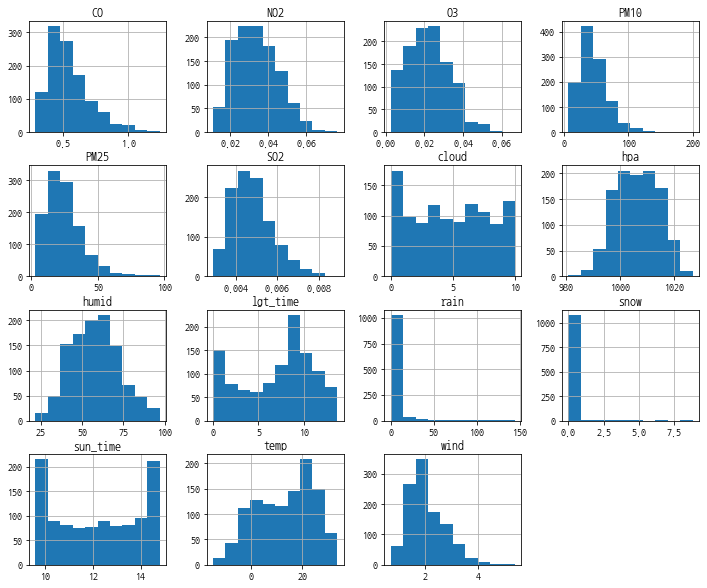

In [11]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

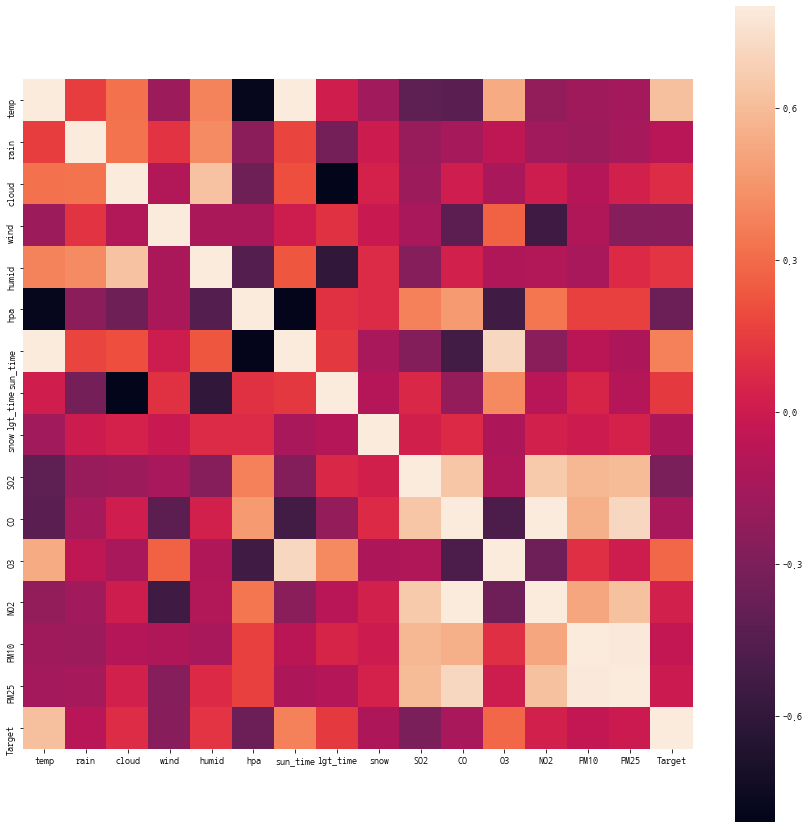

In [12]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [13]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [14]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 15)

In [15]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 14:41:26.815456  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 14:41:26.834435  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 14:41:26.836401  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 14:41:26.895266  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


#### =========='GS-탄산음료date-Weights-258--595.10015.hdf5'파일이 안주어지면 실행.(있으면 실행 필요없음)==========

In [16]:
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [17]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 14:41:32.972234  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 14:41:33.085937  2924 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 528us/step - loss: 5480.1420 - mean_absolute_error: 5480.1420 - val_loss: 3423.1874 - val_mean_absolute_error: 3423.1874

Epoch 00001: val_loss improved from inf to 3423.18741, saving model to GS-탄산음료date-Weights-001--3423.18741.hdf5
Epoch 2/500
585/585 [==============================] - 0s 78us/step - loss: 1884.2015 - mean_absolute_error: 1884.2015 - val_loss: 1101.1559 - val_mean_absolute_error: 1101.1559

Epoch 00002: val_loss improved from 3423.18741 to 1101.15594, saving model to GS-탄산음료date-Weights-002--1101.15594.hdf5
Epoch 3/500
585/585 [==============================] - 0s 78us/step - loss: 1439.2063 - mean_absolute_error: 1439.2063 - val_loss: 806.2378 - val_mean_absolute_error: 806.2378

Epoch 00003: val_loss improved from 1101.15594 to 806.23775, saving model to GS-탄산음료date-Weights-003--806.23775.hdf5
Epoch 4/500
585/585 [==============================] - 0s 75us/step - 

585/585 [==============================] - 0s 80us/step - loss: 1084.1326 - mean_absolute_error: 1084.1326 - val_loss: 814.9489 - val_mean_absolute_error: 814.9489

Epoch 00034: val_loss did not improve from 622.69054
Epoch 35/500
585/585 [==============================] - 0s 80us/step - loss: 1044.1386 - mean_absolute_error: 1044.1386 - val_loss: 816.3071 - val_mean_absolute_error: 816.3071

Epoch 00035: val_loss did not improve from 622.69054
Epoch 36/500
585/585 [==============================] - 0s 72us/step - loss: 1093.6815 - mean_absolute_error: 1093.6815 - val_loss: 929.3905 - val_mean_absolute_error: 929.3905

Epoch 00036: val_loss did not improve from 622.69054
Epoch 37/500
585/585 [==============================] - 0s 77us/step - loss: 1073.0707 - mean_absolute_error: 1073.0707 - val_loss: 848.6921 - val_mean_absolute_error: 848.6921

Epoch 00037: val_loss did not improve from 622.69054
Epoch 38/500
585/585 [==============================] - 0s 77us/step - loss: 1025.1129 - 


Epoch 00069: val_loss did not improve from 622.69054
Epoch 70/500
585/585 [==============================] - 0s 89us/step - loss: 1025.2627 - mean_absolute_error: 1025.2627 - val_loss: 862.7738 - val_mean_absolute_error: 862.7738

Epoch 00070: val_loss did not improve from 622.69054
Epoch 71/500
585/585 [==============================] - 0s 78us/step - loss: 999.5061 - mean_absolute_error: 999.5061 - val_loss: 803.9833 - val_mean_absolute_error: 803.9833

Epoch 00071: val_loss did not improve from 622.69054
Epoch 72/500
585/585 [==============================] - 0s 78us/step - loss: 1008.4571 - mean_absolute_error: 1008.4571 - val_loss: 863.0701 - val_mean_absolute_error: 863.0701

Epoch 00072: val_loss did not improve from 622.69054
Epoch 73/500
585/585 [==============================] - 0s 72us/step - loss: 1000.2863 - mean_absolute_error: 1000.2863 - val_loss: 876.2655 - val_mean_absolute_error: 876.2655

Epoch 00073: val_loss did not improve from 622.69054
Epoch 74/500
585/585 [==

585/585 [==============================] - 0s 89us/step - loss: 1078.0151 - mean_absolute_error: 1078.0151 - val_loss: 814.8712 - val_mean_absolute_error: 814.8712

Epoch 00105: val_loss did not improve from 622.69054
Epoch 106/500
585/585 [==============================] - 0s 85us/step - loss: 1043.7985 - mean_absolute_error: 1043.7985 - val_loss: 887.2649 - val_mean_absolute_error: 887.2649

Epoch 00106: val_loss did not improve from 622.69054
Epoch 107/500
585/585 [==============================] - 0s 84us/step - loss: 991.2757 - mean_absolute_error: 991.2757 - val_loss: 808.9656 - val_mean_absolute_error: 808.9656

Epoch 00107: val_loss did not improve from 622.69054
Epoch 108/500
585/585 [==============================] - 0s 73us/step - loss: 990.6972 - mean_absolute_error: 990.6972 - val_loss: 849.9490 - val_mean_absolute_error: 849.9490

Epoch 00108: val_loss did not improve from 622.69054
Epoch 109/500
585/585 [==============================] - 0s 76us/step - loss: 995.7410 - m


Epoch 00140: val_loss did not improve from 622.69054
Epoch 141/500
585/585 [==============================] - 0s 80us/step - loss: 975.5463 - mean_absolute_error: 975.5463 - val_loss: 743.7908 - val_mean_absolute_error: 743.7908

Epoch 00141: val_loss did not improve from 622.69054
Epoch 142/500
585/585 [==============================] - 0s 75us/step - loss: 992.1687 - mean_absolute_error: 992.1687 - val_loss: 808.5618 - val_mean_absolute_error: 808.5618

Epoch 00142: val_loss did not improve from 622.69054
Epoch 143/500
585/585 [==============================] - 0s 78us/step - loss: 981.9154 - mean_absolute_error: 981.9154 - val_loss: 761.0511 - val_mean_absolute_error: 761.0511

Epoch 00143: val_loss did not improve from 622.69054
Epoch 144/500
585/585 [==============================] - 0s 77us/step - loss: 1015.9591 - mean_absolute_error: 1015.9591 - val_loss: 783.9846 - val_mean_absolute_error: 783.9846

Epoch 00144: val_loss did not improve from 622.69054
Epoch 145/500
585/585 [=

585/585 [==============================] - 0s 84us/step - loss: 939.4702 - mean_absolute_error: 939.4702 - val_loss: 772.7562 - val_mean_absolute_error: 772.7562

Epoch 00176: val_loss did not improve from 622.69054
Epoch 177/500
585/585 [==============================] - 0s 80us/step - loss: 953.1654 - mean_absolute_error: 953.1654 - val_loss: 698.2889 - val_mean_absolute_error: 698.2889

Epoch 00177: val_loss did not improve from 622.69054
Epoch 178/500
585/585 [==============================] - 0s 78us/step - loss: 943.8918 - mean_absolute_error: 943.8918 - val_loss: 922.2452 - val_mean_absolute_error: 922.2452

Epoch 00178: val_loss did not improve from 622.69054
Epoch 179/500
585/585 [==============================] - 0s 72us/step - loss: 960.1068 - mean_absolute_error: 960.1068 - val_loss: 708.0551 - val_mean_absolute_error: 708.0551

Epoch 00179: val_loss did not improve from 622.69054
Epoch 180/500
585/585 [==============================] - 0s 77us/step - loss: 932.2497 - mean_


Epoch 00211: val_loss did not improve from 622.69054
Epoch 212/500
585/585 [==============================] - 0s 78us/step - loss: 931.3290 - mean_absolute_error: 931.3290 - val_loss: 821.8738 - val_mean_absolute_error: 821.8738

Epoch 00212: val_loss did not improve from 622.69054
Epoch 213/500
585/585 [==============================] - 0s 77us/step - loss: 952.7376 - mean_absolute_error: 952.7376 - val_loss: 787.6813 - val_mean_absolute_error: 787.6813

Epoch 00213: val_loss did not improve from 622.69054
Epoch 214/500
585/585 [==============================] - 0s 75us/step - loss: 934.3743 - mean_absolute_error: 934.3743 - val_loss: 681.5412 - val_mean_absolute_error: 681.5412

Epoch 00214: val_loss did not improve from 622.69054
Epoch 215/500
585/585 [==============================] - 0s 80us/step - loss: 939.2954 - mean_absolute_error: 939.2954 - val_loss: 721.6371 - val_mean_absolute_error: 721.6371

Epoch 00215: val_loss did not improve from 622.69054
Epoch 216/500
585/585 [===

585/585 [==============================] - 0s 78us/step - loss: 939.4542 - mean_absolute_error: 939.4542 - val_loss: 727.6628 - val_mean_absolute_error: 727.6628

Epoch 00247: val_loss did not improve from 622.69054
Epoch 248/500
585/585 [==============================] - 0s 75us/step - loss: 961.8568 - mean_absolute_error: 961.8568 - val_loss: 755.3494 - val_mean_absolute_error: 755.3494

Epoch 00248: val_loss did not improve from 622.69054
Epoch 249/500
585/585 [==============================] - 0s 78us/step - loss: 916.2402 - mean_absolute_error: 916.2402 - val_loss: 701.0284 - val_mean_absolute_error: 701.0284

Epoch 00249: val_loss did not improve from 622.69054
Epoch 250/500
585/585 [==============================] - 0s 77us/step - loss: 912.9279 - mean_absolute_error: 912.9279 - val_loss: 752.4782 - val_mean_absolute_error: 752.4782

Epoch 00250: val_loss did not improve from 622.69054
Epoch 251/500
585/585 [==============================] - 0s 78us/step - loss: 944.3232 - mean_

585/585 [==============================] - 0s 78us/step - loss: 912.0460 - mean_absolute_error: 912.0460 - val_loss: 789.7869 - val_mean_absolute_error: 789.7869

Epoch 00282: val_loss did not improve from 595.10015
Epoch 283/500
585/585 [==============================] - 0s 86us/step - loss: 901.7732 - mean_absolute_error: 901.7732 - val_loss: 661.9902 - val_mean_absolute_error: 661.9902

Epoch 00283: val_loss did not improve from 595.10015
Epoch 284/500
585/585 [==============================] - 0s 77us/step - loss: 935.7932 - mean_absolute_error: 935.7932 - val_loss: 815.8558 - val_mean_absolute_error: 815.8558

Epoch 00284: val_loss did not improve from 595.10015
Epoch 285/500
585/585 [==============================] - 0s 79us/step - loss: 958.5063 - mean_absolute_error: 958.5063 - val_loss: 657.3929 - val_mean_absolute_error: 657.3929

Epoch 00285: val_loss did not improve from 595.10015
Epoch 286/500
585/585 [==============================] - 0s 80us/step - loss: 896.6774 - mean_

585/585 [==============================] - 0s 82us/step - loss: 959.6991 - mean_absolute_error: 959.6991 - val_loss: 796.7547 - val_mean_absolute_error: 796.7547

Epoch 00317: val_loss did not improve from 595.10015
Epoch 318/500
585/585 [==============================] - 0s 85us/step - loss: 890.6927 - mean_absolute_error: 890.6927 - val_loss: 757.7128 - val_mean_absolute_error: 757.7128

Epoch 00318: val_loss did not improve from 595.10015
Epoch 319/500
585/585 [==============================] - 0s 82us/step - loss: 887.2600 - mean_absolute_error: 887.2600 - val_loss: 639.5349 - val_mean_absolute_error: 639.5349

Epoch 00319: val_loss did not improve from 595.10015
Epoch 320/500
585/585 [==============================] - 0s 84us/step - loss: 963.3857 - mean_absolute_error: 963.3857 - val_loss: 833.5580 - val_mean_absolute_error: 833.5580

Epoch 00320: val_loss did not improve from 595.10015
Epoch 321/500
585/585 [==============================] - 0s 82us/step - loss: 922.7063 - mean_


Epoch 00352: val_loss did not improve from 595.10015
Epoch 353/500
585/585 [==============================] - 0s 85us/step - loss: 861.2569 - mean_absolute_error: 861.2569 - val_loss: 685.8325 - val_mean_absolute_error: 685.8325

Epoch 00353: val_loss did not improve from 595.10015
Epoch 354/500
585/585 [==============================] - 0s 90us/step - loss: 890.3575 - mean_absolute_error: 890.3575 - val_loss: 869.9821 - val_mean_absolute_error: 869.9821

Epoch 00354: val_loss did not improve from 595.10015
Epoch 355/500
585/585 [==============================] - 0s 92us/step - loss: 879.8632 - mean_absolute_error: 879.8632 - val_loss: 894.9372 - val_mean_absolute_error: 894.9372

Epoch 00355: val_loss did not improve from 595.10015
Epoch 356/500
585/585 [==============================] - 0s 87us/step - loss: 901.9709 - mean_absolute_error: 901.9709 - val_loss: 619.5637 - val_mean_absolute_error: 619.5637

Epoch 00356: val_loss did not improve from 595.10015
Epoch 357/500
585/585 [===

585/585 [==============================] - 0s 94us/step - loss: 875.1365 - mean_absolute_error: 875.1365 - val_loss: 679.9540 - val_mean_absolute_error: 679.9540

Epoch 00388: val_loss did not improve from 595.10015
Epoch 389/500
585/585 [==============================] - 0s 90us/step - loss: 867.9213 - mean_absolute_error: 867.9213 - val_loss: 817.7804 - val_mean_absolute_error: 817.7804

Epoch 00389: val_loss did not improve from 595.10015
Epoch 390/500
585/585 [==============================] - 0s 89us/step - loss: 871.1814 - mean_absolute_error: 871.1814 - val_loss: 717.3357 - val_mean_absolute_error: 717.3357

Epoch 00390: val_loss did not improve from 595.10015
Epoch 391/500
585/585 [==============================] - 0s 95us/step - loss: 889.0300 - mean_absolute_error: 889.0300 - val_loss: 729.6555 - val_mean_absolute_error: 729.6555

Epoch 00391: val_loss did not improve from 595.10015
Epoch 392/500
585/585 [==============================] - 0s 92us/step - loss: 884.1827 - mean_


Epoch 00423: val_loss did not improve from 595.10015
Epoch 424/500
585/585 [==============================] - 0s 95us/step - loss: 854.9108 - mean_absolute_error: 854.9108 - val_loss: 725.9005 - val_mean_absolute_error: 725.9005

Epoch 00424: val_loss did not improve from 595.10015
Epoch 425/500
585/585 [==============================] - 0s 94us/step - loss: 877.0601 - mean_absolute_error: 877.0601 - val_loss: 1012.7116 - val_mean_absolute_error: 1012.7116

Epoch 00425: val_loss did not improve from 595.10015
Epoch 426/500
585/585 [==============================] - 0s 92us/step - loss: 874.9499 - mean_absolute_error: 874.9499 - val_loss: 837.3232 - val_mean_absolute_error: 837.3232

Epoch 00426: val_loss did not improve from 595.10015
Epoch 427/500
585/585 [==============================] - 0s 94us/step - loss: 857.2106 - mean_absolute_error: 857.2106 - val_loss: 787.8778 - val_mean_absolute_error: 787.8778

Epoch 00427: val_loss did not improve from 595.10015
Epoch 428/500
585/585 [=

585/585 [==============================] - 0s 130us/step - loss: 873.2352 - mean_absolute_error: 873.2352 - val_loss: 736.8473 - val_mean_absolute_error: 736.8473

Epoch 00459: val_loss did not improve from 595.10015
Epoch 460/500
585/585 [==============================] - 0s 119us/step - loss: 889.0736 - mean_absolute_error: 889.0736 - val_loss: 818.2449 - val_mean_absolute_error: 818.2449

Epoch 00460: val_loss did not improve from 595.10015
Epoch 461/500
585/585 [==============================] - 0s 114us/step - loss: 841.0918 - mean_absolute_error: 841.0918 - val_loss: 779.1406 - val_mean_absolute_error: 779.1406

Epoch 00461: val_loss did not improve from 595.10015
Epoch 462/500
585/585 [==============================] - 0s 111us/step - loss: 850.5418 - mean_absolute_error: 850.5418 - val_loss: 703.8728 - val_mean_absolute_error: 703.8728

Epoch 00462: val_loss did not improve from 595.10015
Epoch 463/500
585/585 [==============================] - 0s 114us/step - loss: 896.3630 - 


Epoch 00494: val_loss did not improve from 595.10015
Epoch 495/500
585/585 [==============================] - 0s 121us/step - loss: 836.6955 - mean_absolute_error: 836.6955 - val_loss: 817.5967 - val_mean_absolute_error: 817.5967

Epoch 00495: val_loss did not improve from 595.10015
Epoch 496/500
585/585 [==============================] - 0s 121us/step - loss: 830.4473 - mean_absolute_error: 830.4473 - val_loss: 943.1861 - val_mean_absolute_error: 943.1861

Epoch 00496: val_loss did not improve from 595.10015
Epoch 497/500
585/585 [==============================] - 0s 114us/step - loss: 881.8601 - mean_absolute_error: 881.8601 - val_loss: 846.9274 - val_mean_absolute_error: 846.9274

Epoch 00497: val_loss did not improve from 595.10015
Epoch 498/500
585/585 [==============================] - 0s 104us/step - loss: 855.9873 - mean_absolute_error: 855.9873 - val_loss: 836.3909 - val_mean_absolute_error: 836.3909

Epoch 00498: val_loss did not improve from 595.10015
Epoch 499/500
585/585 

#### ====================================================================================================

In [18]:
# Load wights file of the best model :
wights_file = 'GS-탄산음료date-Weights-258--595.10015.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [19]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [20]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  790.2185792349727


In [21]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

[14:43:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  724.6771607112363


In [22]:
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = gs_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1096, 1)
randomforest 예상 (1096,)
XGBpredictions (1096,)


In [23]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

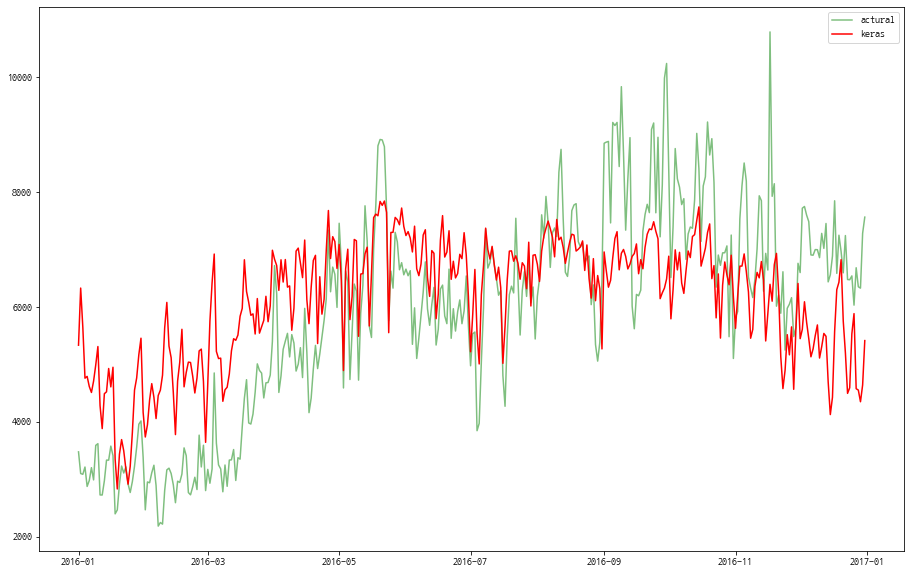

In [24]:
# 2016
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

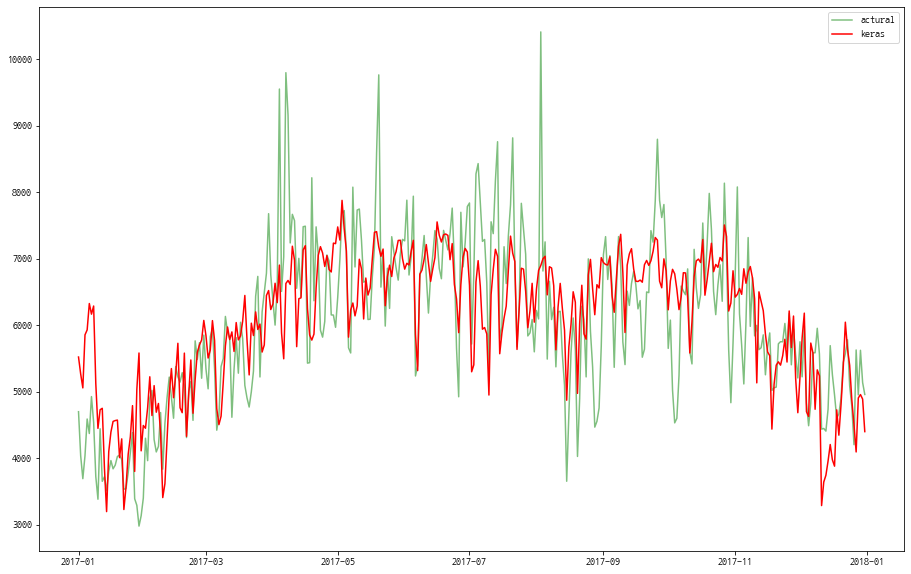

In [25]:
# 2017
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

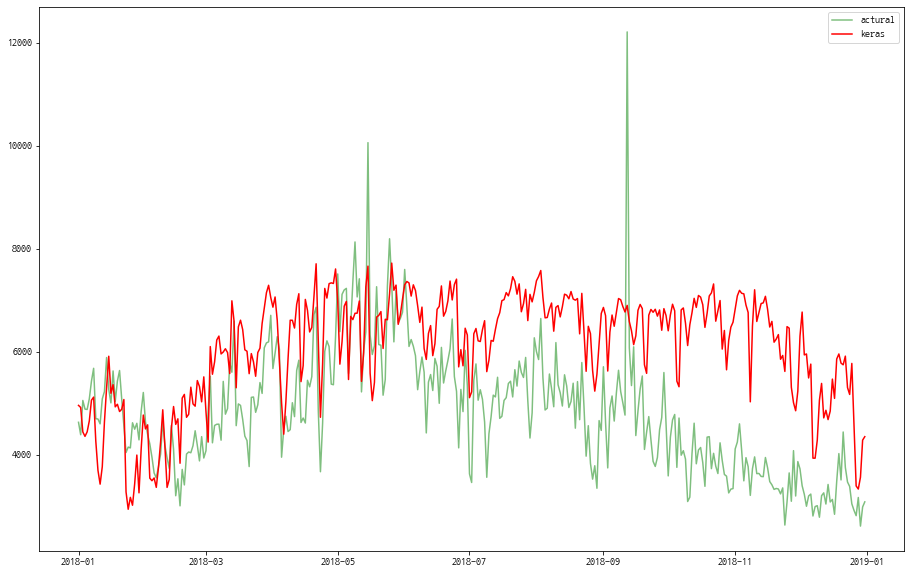

In [26]:
# 2018
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

W0717 14:43:54.710952  2924 legend.py:1282] No handles with labels found to put in legend.


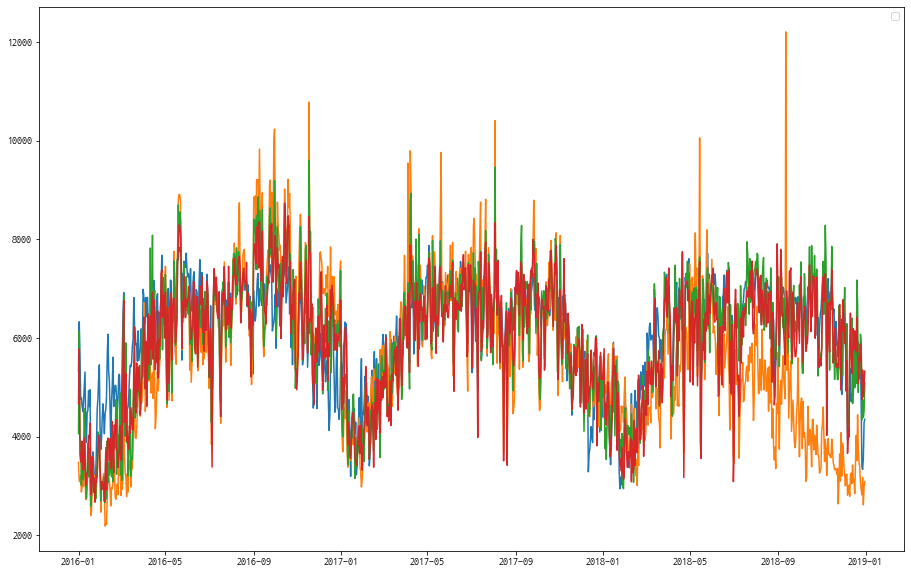

In [27]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.keras_qty)
plt.plot(result_df.date,result_df.qty)
plt.plot(result_df.date,result_df.rf_qty)
plt.plot(result_df.date,result_df.xgb_qty)
plt.legend()
plt.show()

In [28]:
result_df['qtyMinusMean'] = (result_df.qty-np.mean(result_df.qty) )
result_df['qtyMinusMeanSquared'] = (result_df.qty-np.mean(result_df.qty) )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty-np.mean(result_df.qty))**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty-np.mean(result_df.qty))**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty-np.mean(result_df.qty))**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.5459155498178084
rf R-sq 0.7401992302177522
xgb R-sq 0.6725253962378381


In [29]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)